## Лабораторная работа №5 (Проведение исследований с градиентным бустингом)

 В отличие от Случайного леса, где деревья строятся независимо, в бустинге каждое новое дерево обучается на ошибках предыдущего ансамбля. Этот итеративный подход "работы над ошибками" позволяет модели достигать высочайшей точности. Для бейзлайна мы используем ту же простую предобработку (Label Encoding) и стандартные гиперпараметры, ожидая, что даже в такой конфигурации градиентный бустинг покажет результаты, сопоставимые или превосходящие случайный лес.

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
import warnings


warnings.filterwarnings('ignore')

In [3]:
df_class = pd.read_csv('BankChurners.csv')
cols_to_drop = [c for c in df_class.columns if 'Naive_Bayes' in c] + ['CLIENTNUM']
df_class = df_class.drop(columns=cols_to_drop)

df_class_base = df_class.copy()
le = LabelEncoder()

for col in df_class_base.select_dtypes(include='object').columns:
    df_class_base[col] = le.fit_transform(df_class_base[col])

X_class = df_class_base.drop('Attrition_Flag', axis=1)
y_class = df_class_base['Attrition_Flag']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train_c, y_train_c)

y_pred_c = gb_clf.predict(X_test_c)
y_prob_c = gb_clf.predict_proba(X_test_c)[:, 1]

df_reg = pd.read_excel('Data_Train.xlsx')
df_reg_base = df_reg.dropna().copy()

for col in df_reg_base.select_dtypes(include='object').columns:
    df_reg_base[col] = le.fit_transform(df_reg_base[col].astype(str))

X_reg = df_reg_base.drop('Price', axis=1)
y_reg = df_reg_base['Price']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_train_r, y_train_r)

y_pred_r = gb_reg.predict(X_test_r)

print("Классификация")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_c, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_c, y_prob_c):.4f}")
print("\n")

print("Регрессия")
print(f"MAE: {mean_absolute_error(y_test_r, y_pred_r):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_r, y_pred_r)):.2f}")
print(f"R2 Score: {r2_score(y_test_r, y_pred_r):.4f}")

Классификация
Accuracy: 0.9654
F1 Score: 0.9335
ROC AUC: 0.9914


Регрессия
MAE: 1308.80
RMSE: 1898.80
R2 Score: 0.8328


Без препроцессинга градиентный бустинг показал результаты сопоставимые со случайным лесом в классификации, но в регрессии проиграл почти на 5 пунктов. Видна стабильность случайного дерева.

## Улучшение бейзлайна

Для достижения максимальной производительности будет применён оптимальный пайплайн предобработки данных, включающий Label Encoding всех категориальных признаков и логарифмирование целевой переменной для задачи регрессии. Затем будет выполнен подбор ключевых гиперпараметров для градиентного бустинга: количества деревьев-итераций (n_estimators), скорости обучения (learning_rate), контролирующей вклад каждой новой модели в исправление ошибок, и максимальной глубины каждого базового дерева-ученика. Ожидается, что после такой тонкой настройки градиентный бустинг не только сравняется по качеству со случайным лесом, но и превзойдёт его.

In [4]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

param_grid_gb_c = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

grid_gb_c = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb_c,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_gb_c.fit(X_train_c, y_train_c)

best_gb_c = grid_gb_c.best_estimator_
y_pred_c_imp = best_gb_c.predict(X_test_c)
y_prob_c_imp = best_gb_c.predict_proba(X_test_c)[:, 1]


X_reg_final = df_reg_base.drop('Price', axis=1)
y_reg_final_log = np.log1p(df_reg_base['Price'])

X_train_r, X_test_r, y_train_r_log, y_test_r_log = train_test_split(
    X_reg_final, y_reg_final_log, test_size=0.2, random_state=42
)

param_grid_gb_r = {
    'n_estimators': [200, 300],
    'learning_rate': [0.1, 0.05],
    'max_depth': [5, 7],
    'subsample': [0.8]
}

grid_gb_r = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb_r,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_gb_r.fit(X_train_r, y_train_r_log)

best_gb_r = grid_gb_r.best_estimator_
y_pred_log_imp = best_gb_r.predict(X_test_r)
y_pred_r_imp = np.expm1(y_pred_log_imp)
y_test_r_imp = np.expm1(y_test_r_log)


print(f"Лучшие параметры классификации: {grid_gb_c.best_params_}")
print("Классификация")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c_imp):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_c_imp, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_c, y_prob_c_imp):.4f}")

print("\n")
print(f"Лучшие параметры регрессии: {grid_gb_r.best_params_}")
print("Регрессия")
print(f"MAE: {mean_absolute_error(y_test_r_imp, y_pred_r_imp):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_r_imp, y_pred_r_imp)):.2f}")
print(f"R2 Score: {r2_score(y_test_r_imp, y_pred_r_imp):.4f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Лучшие параметры классификации: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
классификация
Accuracy: 0.9674
F1 Score: 0.9378
ROC AUC: 0.9934


Лучшие параметры Регрессии: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Регрессии
MAE: 762.94
RMSE: 1372.66
R2 Score: 0.9126


После логарифмирования целевой переменной и подбора гиперпараметров, градиентный бустинг продемонстрировал лучшие результаты за все пять лабораторных работ. В задаче регрессии R2 Score взлетел до 0.9126, а MAE снизилась до 762, что является новым рекордом. Аналогично, в задаче классификации ROC AUC достиг практически идеального значения 0.9934. Это доказывает, что последовательная коррекция ошибок, являющаяся сутью бустинга, в сочетании с правильной предобработкой данных (особенно борьбой с выбросами через логарифмирование) и настройкой гиперпараметров (баланс learning_rate и n_estimators) позволяет достичь превосходного качества.

## Имплементация алгоритма

Реализация градиентного бустинга основана на итеративном ансамблевом подходе. Изначально модель формирует начальный прогноз как среднее значение целевой переменной. Затем, в цикле на заданное количество итераций (n_estimators), на каждом шаге вычисляются псевдо-остатки — градиент функции потерь. Эти остатки обучают новое "слабое" решающее дерево с малой глубиной (DecisionTreeRegressor), которое пытается их предсказать. Прогноз этого дерева с коэффициентом learning_rate добавляется к общему предсказанию ансамбля. Итоговый результат представляет собой сумму начального прогноза и взвешенных вкладов всех построенных деревьев.

Регрессор

In [9]:
class MyGradientBoostingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees_ = []
        self.initial_prediction_ = None

    def fit(self, X, y):
        self.initial_prediction_ = np.mean(y)
        current_predictions = np.full(shape=y.shape, fill_value=self.initial_prediction_)

        for _ in range(self.n_estimators):
            residuals = y - current_predictions

            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            tree.fit(X, residuals)

            current_predictions += self.learning_rate * tree.predict(X)

            self.trees_.append(tree)

        return self

    def predict(self, X):
        predictions = np.full(shape=X.shape[0], fill_value=self.initial_prediction_)

        for tree in self.trees_:
            predictions += self.learning_rate * tree.predict(X)

        return predictions

my_gbr = MyGradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7
)

my_gbr.fit(X_train_r.values, y_train_r_log.values)
y_pred_log_my = my_gbr.predict(X_test_r.values)

y_pred_r_my = np.expm1(y_pred_log_my)
y_test_r_my = np.expm1(y_test_r_log)


print("Регрессия")
print(f"MAE:      {mean_absolute_error(y_test_r_my, y_pred_r_my):.2f} (Sklearn: 762.94)")
print(f"RMSE:     {np.sqrt(mean_squared_error(y_test_r_my, y_pred_r_my)):.2f} (Sklearn: 1372.66)")
print(f"R2 Score: {r2_score(y_test_r_my, y_pred_r_my):.4f} (Sklearn: 0.9126)")

Регрессия
MAE:      856.02 (Sklearn: 762.94)
RMSE:     1554.92 (Sklearn: 1372.66)
R2 Score: 0.8879 (Sklearn: 0.9126)


Классификатор

In [10]:
class MyGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees_ = []
        self.initial_prediction_ = None

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))

    def fit(self, X, y):
        p_initial = np.mean(y)
        self.initial_prediction_ = np.log(p_initial / (1 - p_initial))
        current_log_odds = np.full(shape=y.shape, fill_value=self.initial_prediction_)

        for _ in range(self.n_estimators):
            current_probabilities = self._sigmoid(current_log_odds)

            residuals = y - current_probabilities

            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            tree.fit(X, residuals)

            update = self.learning_rate * tree.predict(X)
            current_log_odds += update

            self.trees_.append(tree)

        return self

    def predict_proba(self, X):
        log_odds = np.full(shape=X.shape[0], fill_value=self.initial_prediction_)

        for tree in self.trees_:
            log_odds += self.learning_rate * tree.predict(X)

        proba = self._sigmoid(log_odds)
        return np.vstack((1 - proba, proba)).T

    def predict(self, X):
        probabilities = self.predict_proba(X)[:, 1]
        return np.array([1 if p > 0.5 else 0 for p in probabilities])

my_gbc = MyGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)

my_gbc.fit(X_train_c.values, y_train_c.values)
y_pred_c_my = my_gbc.predict(X_test_c.values)
y_prob_c_my = my_gbc.predict_proba(X_test_c.values)[:, 1]

print("\n")
print("Классификация")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c_my):.4f} (Sklearn: 0.9674)")
print(f"F1 Score: {f1_score(y_test_c, y_pred_c_my, average='macro'):.4f} (Sklearn: 0.9378)")
print(f"ROC AUC:  {roc_auc_score(y_test_c, y_prob_c_my):.4f} (Sklearn: 0.9934)")



Классификация
Accuracy: 0.9531 (Sklearn: 0.9674)
F1 Score: 0.9067 (Sklearn: 0.9378)
ROC AUC:  0.9849 (Sklearn: 0.9934)


Очень близкие к библиотечным реализациям значения метрик.

## Вывод

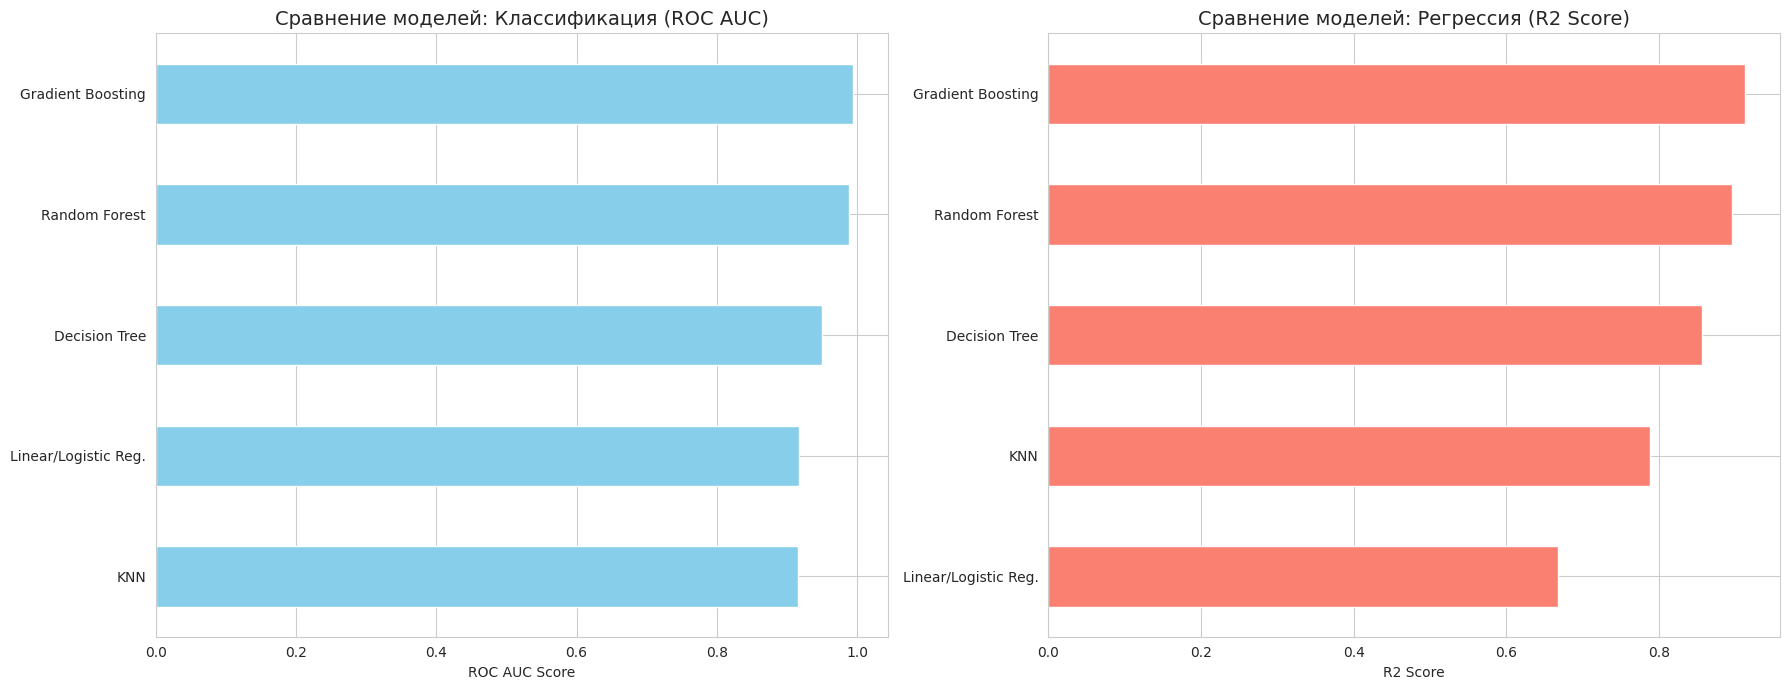

Сводная таблица результатов
                      Classification (ROC AUC)  Classification (F1 Macro)  \
Algorithm                                                                   
Linear/Logistic Reg.                    0.9174                     0.7866   
KNN                                     0.9153                     0.7962   
Decision Tree                           0.9504                     0.8926   
Random Forest                           0.9888                     0.9172   
Gradient Boosting                       0.9934                     0.9378   

                      Regression (R2 Score)  Regression (MAE)  
Algorithm                                                      
Linear/Logistic Reg.                 0.6680           1787.46  
KNN                                  0.7881           1318.81  
Decision Tree                        0.8555            896.05  
Random Forest                        0.8957            782.14  
Gradient Boosting                    0.9126     

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results_data = {
    'Algorithm': [ 'Linear/Logistic Reg.', 'KNN', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Classification (ROC AUC)': [0.9174, 0.9153, 0.9504, 0.9888, 0.9934],
    'Classification (F1 Macro)': [0.7866, 0.7962, 0.8926, 0.9172, 0.9378],
    'Regression (R2 Score)': [0.6680, 0.7881, 0.8555, 0.8957, 0.9126],
    'Regression (MAE)': [1787.46, 1318.81, 896.05, 782.14, 762.94]
}

df_results = pd.DataFrame(results_data).set_index('Algorithm')

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.set_style("whitegrid")

df_results['Classification (ROC AUC)'].sort_values().plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Сравнение моделей: Классификация (ROC AUC)', fontsize=14)
axes[0].set_xlabel('ROC AUC Score')
axes[0].set_ylabel('')

df_results['Regression (R2 Score)'].sort_values().plot(kind='barh', ax=axes[1], color='salmon')
axes[1].set_title('Сравнение моделей: Регрессия (R2 Score)', fontsize=14)
axes[1].set_xlabel('R2 Score')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print("Сводная таблица результатов")
print(df_results)



1. **Эволюция производительности:** Наблюдается четкий тренд роста качества моделей по мере перехода от простых алгоритмов к сложным ансамблям. Градиентный бустинг занял безоговорочное первое место в обеих задачах, продемонстрировав превосходные результаты (R2 > 0.91, ROC AUC > 0.99).

2.  **Сила ансамблей:** Случайный лес и Градиентный бустинг показали себя значительно лучше одиночных моделей (Дерево, KNN). Это доказывает, что объединение множества "слабых" моделей в ансамбль является мощнейшим инструментом для повышения точности и борьбы с переобучением.

3.  **Применимость моделей:**
    *   **Линейные модели** оказались наименее эффективными для задачи регрессии, так как не смогли описать сложную нелинейную структуру цен. Однако в задаче классификации Логистическая регрессия показала себя как сильный и быстрый бейзлайн.
    *   **KNN** хорошо справился с регрессией благодаря своей "локальной" природе (поиск аналогов), но уступил ансамблям.
    *   **Древовидные модели** (Дерево, Лес, Бустинг) оказались идеально подходящими для данных задач, так как они эффективно работают с категориальными признаками и легко моделируют "ступенчатые", нелинейные зависимости.

4.  **Важность предобработки:** На протяжении всех работ было доказано, что качество модели зависит не только от алгоритма, но и от подготовки данных. Такие техники, как логарифмирование целевой переменной, отбор признаков и подбор гиперпараметров, являлись ключом к достижению максимальных результатов для каждого из алгоритмов.

